 # Assignment 2: Classification Modeling  
 Jason Adam  
 ## Background Data
*  Use three binary explanatory variables relating to client banking history: ***default, housing, and loan***
*  Predict the binary response variable: ***Has the client subscribed to a term deposit?***  
*  Employ two classification methods: ***(1) logistic regression*** as described in Chapter 4 of the Géron (2017) textbook and ***(2) naïve Bayes classification***.  
*  Evaluate these methods within a cross-validation design, using the area under the receiver operating characteristic (ROC) curve as an index of classification performance.  
*  Use scikit-learn as primary ML library.  

## Management Questions
Regarding the management problem, imagine that you are advising the bank about machine learning methods to guide telephone marketing campaigns. Which of the two modeling methods would you recommend and why? And, given the results of your research, which group of banking clients appears to be the best target for direct marketing efforts (similar to those used with previous telephone campaigns)? 

# Setup & Data Ingest  
Load necessary libraries and intial dataset.

## Initial Imports

In [0]:
# Load Initial Libraries
import numpy as np
import pandas as pd

## Initial Dataframe(s) Creation
Using public github link to csv file

In [0]:
# Read in bank.csv from public githup link
bank = pd.read_csv('https://raw.githubusercontent.com/Jason-Adam/msds-422/master/data/bank.csv', sep=';')

# Exploratory Data Analysis (EDA)

## Data Cleaning

### Review Dataframe and Drop NAs

In [0]:
# View top rows of data
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [0]:
# Examine the shape of the inital dataframe
print('The dataframe has {0} rows and {1} columns'.format(bank.shape[0],
                                                         bank.shape[1]))

The dataframe has 4521 rows and 17 columns


In [0]:
# Drop missing observations
bank.dropna()

# Examine new shape of dataframe
print(bank.shape)

(4521, 17)


*It appears that there were no missing values in the dataframe, hence we did not lose any observations.*

In [0]:
# Review columns
list(bank.columns.values)

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'response']

### Create Binary Mapping for Variables  
This will change the yes/no variables to 1 or 0

In [0]:
# Mapping function to convert text no/yes to integer 0/1
convert_to_binary = {'no' : 0, 'yes' : 1}

# Define binary variable for having credit in default
default = bank['default'].map(convert_to_binary)

# Define binary variable for having a mortgage or housing loan
housing = bank['housing'].map(convert_to_binary)

# Define binary variable for having a personal loan
loan = bank['loan'].map(convert_to_binary)

# Define response variable to use in the model
response = bank['response'].map(convert_to_binary)

In [0]:
# Combine into model data frame
model_df = pd.DataFrame({
    'default': default,
    'housing': housing,
    'loan': loan,
    'response': response
})

model_df.head()

,default,housing,loan,response
0,0,0,0,0
1,0,1,1,0
2,0,1,0,0
3,0,1,1,0
4,0,1,0,0


## Train - Test Split  
We will split into train and test prior to performing any visualizations

In [0]:
# Import sklearn train test split
from sklearn.model_selection import train_test_split

In [0]:
# Split into train and test sets
train_set, test_set = train_test_split(model_df, test_size=0.2, random_state=86)

In [0]:
# Verify that the split occurred
train_shape = train_set.shape
test_shape = test_set.shape

print('Train set shape = {0}'.format(train_shape))
print('Test set shape = {0}'.format(test_shape))

Train set shape = (3616, 4)
Test set shape = (905, 4)


In [0]:
# View columns
train_set.head()

,default,housing,loan,response
2529,0,0,0,0
3959,0,0,0,0
900,0,0,0,0
4304,0,1,0,0
424,0,1,0,0


## Visualizations

### Visualization Imports

In [0]:
# Import visualiztion libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# Create copy as to not modify train set during exploration
viz_df = train_set.copy()

### Correlation Matrix

In [0]:
# Correlation Matrix
viz_df.corr()

,default,housing,loan,response
default,1.000000,0.004117,0.078590,0.009520
housing,0.004117,1.000000,0.019065,-0.092226
loan,0.078590,0.019065,1.000000,-0.065700
response,0.009520,-0.092226,-0.065700,1.000000


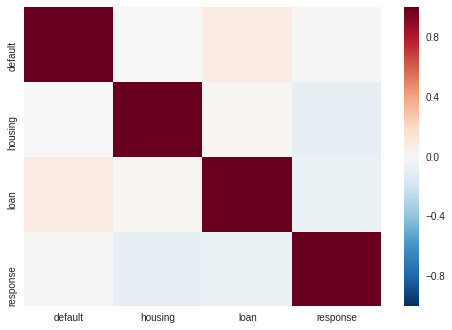

In [0]:
# Creat heatmap correlation matrix
sns.heatmap(viz_df.corr(), xticklabels=corr.columns.values, 
            yticklabels=corr.columns.values)

*This shows us that our variables have very low correlations to our response variable.*

### Response Ratios

In [0]:
# Define function to calculate response ratio
def response_ratio(x):
  '''This function is used to calculate a response ratio'''
  return np.sum(x) / np.size(x)

In [0]:
# Overall response ratio in our training data
resp_ratio = response_ratio(viz_df.response)
print('{0}% of respondents subscribed to long-term deposit.'.format(
    round(resp_ratio * 100, 3)))

11.421% of respondents subscribed to long-term deposit.


*We have a very low rate of positive response in this data set. We need to proceed cautiously in the modeling step.*

In [0]:
# Response rate pivot with all independent variables
pd.pivot_table(viz_df, values='response', index=['default','housing','loan'],
              aggfunc=response_ratio)

response
default housing loan          
0       0       0     0.162471
                1     0.054795
        1       0     0.092082
                1     0.071207
1       0       0     0.230769
                1     0.181818
        1       0     0.130435
                1     0.000000

In [0]:
# Get a sense of how the data is distributed
for i in viz_df.columns:
  ratio = response_ratio(viz_df[i])
  print('{0}% of respondents had a {1}'.format(round(ratio * 100, 1), i))

1.6% of respondents had a default
57.0% of respondents had a housing
15.6% of respondents had a loan
11.4% of respondents had a response


# Modeling

## Logistic Regression

### Imports

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

### Model Fit

#### Create Model Object and Fit to Data

In [0]:
# Create model object
log_reg = LogisticRegression()

In [0]:
# Split the train df into x & y
x_train = train_set[['housing', 'loan', 'default']]
y_train = train_set['response']

# Fit the model
log_reg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
# Review the coefficients
log_reg.coef_

array([[-0.576152  , -0.67772107,  0.32421555]])

In [0]:
# Predict y on the train set
y_pred = log_reg.predict(x_train)

# Calculate the accuracy on the train set
print('Accuracy of logistic regression classifier on train set: {:.4f}'.format(
    log_reg.score(x_train, y_train)))

Accuracy of logistic regression classifier on train set: 0.8858


#### Confusion Matrix

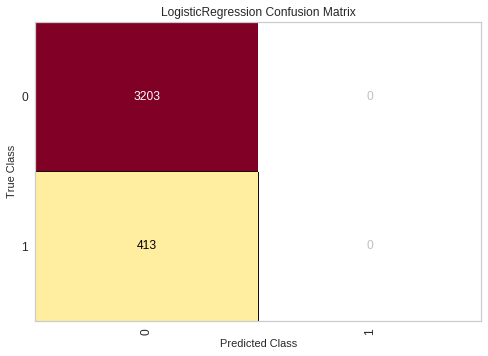

In [0]:
# Create confusion matrix
cm = ConfusionMatrix(log_reg, classes=[0,1])
cm.score(x_train, y_train)
cm.poof()

#### Precision & Recall

In [0]:
# Calculate Scores
prec_score = precision_score(y_train, y_pred)
rec_score = recall_score(y_train, y_pred)
f_one = f1_score(y_train, y_pred)

# Define print function
def precision_recall_f_scores(precision, recall, f_one):
  print('Precision = {}'.format(precision))
  print('Recall = {}'.format(recall))
  print('F1 = {}'.format(f_one))

# Print results
precision_recall_f_scores(prec_score, rec_score, f_one)

Precision = 0.0
Recall = 0.0
F1 = 0.0


#### ROC Curve and AUC

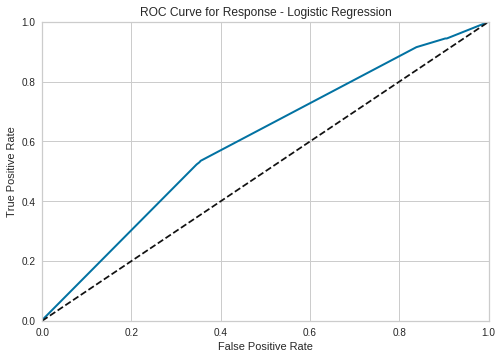

In [0]:
# Calculate Scores
y_scores = log_reg.decision_function(x_train)

# Calculate fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

# Create roc curve plotting function
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.axis([0, 1, 0, 1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')

# Plot the ROC Curve
plot_roc_curve(fpr, tpr)
plt.title('ROC Curve for Response - Logistic Regression')
plt.show()

In [0]:
# Calculate the AUC
roc_auc = roc_auc_score(y_train, y_scores)
print('The area under the curve = {:3f}'.format(roc_auc))

The area under the curve = 0.600549


### Cross Validation

In [0]:
# Get rid of warnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
# Create Cross Validation List to try different values
cv_list = [3,5,10]

# Define function that will return mean accuracy for different CV values
def cross_val_multiple(model, x_train=x_train, y_train=y_train, cv_list=cv_list):
  '''
  This function will take a list of cross validation values and return the
  mean accuracy for a model
  '''
  for i in cv_list:
    cv_accuracy = cross_val_score(model, x_train, y_train, cv=i)
    print('The mean accuracy for {} cross fold validation = {:.6f}'.format(
        i,np.mean(cv_accuracy)))

In [0]:
# Run the cross validation
cross_val_multiple(log_reg)

The mean accuracy for 3 cross fold validation = 0.885786
The mean accuracy for 5 cross fold validation = 0.885786
The mean accuracy for 10 cross fold validation = 0.885788


**Utilizing cross validation hasn't yielded a higher accuracy model**  
If we look back on our initial response ratio, it was roughly 11%, which indicates that our model isn't  
performing any better than a perfectly naive model.

### Run Model Against Test Data

In [0]:
# Split the test df into x & y
x_test = test_set[['housing', 'loan', 'default']]
y_test = test_set['response']

In [0]:
# Make Predictions on test data
y_test_pred = log_reg.predict(x_test)

# Calculate the accuracy on the test set
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(
    log_reg.score(x_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.8807


In [0]:
# View probabilities
log_reg.predict_proba(x_test)

array([[0.90417559, 0.09582441],
       [0.91262176, 0.08737824],
       [0.90417559, 0.09582441],
       ...,
       [0.90417559, 0.09582441],
       [0.90417559, 0.09582441],
       [0.94893433, 0.05106567]])

In [0]:
# Calculate Scores
y_scores_test = log_reg.decision_function(x_test)

# Calculate the AUC
roc_auc = roc_auc_score(y_test, y_scores_test)
print('The area under the curve = {:3f}'.format(roc_auc))

The area under the curve = 0.639772


**I did not use the cross validation model on the test set due to no increase in accuracy.  
Overall, the model performed as expected on the test data, but is still a poor predictor.**

## Naive Bayes Classification

### Imports

In [0]:
# BernoulliNB is designed for binary/boolean features
from sklearn.naive_bayes import BernoulliNB

### Model Fit

#### Create Model Object and Fit to Data

In [0]:
# Create model object
nb_b = BernoulliNB()

# Fit the model
nb_b.fit(x_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [0]:
# Predict y on the train set
y_pred = nb_b.predict(x_train)

# Calculate the accuracy on the train set
print('Accuracy of Naive Bayes classifier on test set: {:.4f}'.format(
    nb_b.score(x_train, y_train)))

Accuracy of Naive Bayes classifier on test set: 0.8858


#### Confusion Matrix

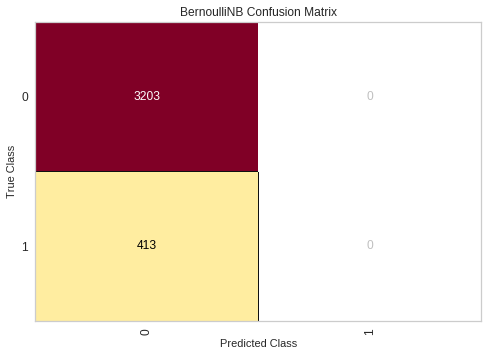

In [0]:
# Create confusion matrix
cm = ConfusionMatrix(nb_b, classes=[0,1])
cm.score(x_train, y_train)
cm.poof()

#### ROC Curve and AUC

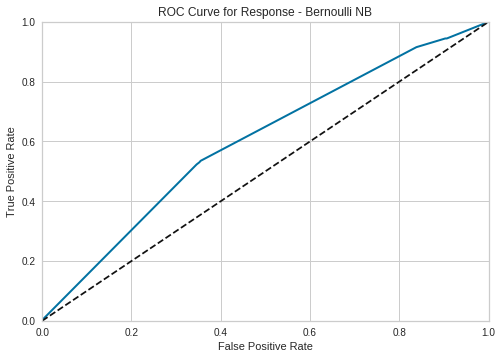

In [0]:
# Calculate Scores
y_scores_nb = nb_b.predict_proba(x_train)

# Calculate fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_train, y_scores_nb[:,1])

# Plot the ROC Curve
plot_roc_curve(fpr, tpr)
plt.title('ROC Curve for Response - Bernoulli NB')
plt.show()

In [0]:
# Calculate the AUC
roc_auc = roc_auc_score(y_train, y_scores_nb[:,1])
print('The area under the curve = {:3f}'.format(roc_auc))

The area under the curve = 0.600549


### Cross Validation

In [0]:
# Run the cross validation
cross_val_multiple(nb_b)

The mean accuracy for 3 cross fold validation = 0.885786
The mean accuracy for 5 cross fold validation = 0.885786
The mean accuracy for 10 cross fold validation = 0.885788


### Run Model Against Test Data

In [0]:
# Make Predictions on test data
y_test_pred = nb_b.predict(x_test)

# Calculate the accuracy on the test set
print('Accuracy of naive bayes classifier on test set: {:.4f}'.format(
    nb_b.score(x_test, y_test)))

Accuracy of naive bayes classifier on test set: 0.8807


In [0]:
# Calculate Scores
y_scores_test = nb_b.predict_proba(x_test)

# Calculate the AUC
roc_auc_nb = roc_auc_score(y_test, y_scores_test[:,1])
print('The area under the curve = {:3f}'.format(roc_auc_nb))

The area under the curve = 0.639772


**The naive bayes classifier has perfomed almost the same as the logistic regression on our test set.**

# Conclusion


*  Neither model performed well.  
*  The accuracy was similar for each model (~88%).  
*  The AUC was nearly identical for each model (~0.639772)
*  The rate of positive responses in the data is ~12% which indicates our achieved accuracy wasn't an improvement over a completely naive model.
*  The variables chosen are not good predictors of whether someone will subscribe to a long-term deposit or not.

# Recommendations to Management


1.   Expand the model to include additional variables that may increase accuracy.  
2.   If management must choose one model, I would recommend the logistic regression. Naive bayes classification assumes all variables are independent and does not take potential interactions between variables into account.
3.   Test different models (possibly Random Forest) against current variables in attempt to raise accuracy and AUC.